# Code Generator RNN

Writing code is hard, so let's make a character-level RNN do it for us
But generating code is also hard, so start with tinyshakespeare first

## Data Collection

Download dataset

In [1]:
# Imports for data collection/processing
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
print(f"Downloaded shakespeare data to {path_to_file}")

Downloaded shakespeare data to /home/theo/.keras/datasets/shakespeare.txt


## Data Processing
1. Grab all java/groovy filenames
2. Convert files into one big string
3. Calculate vocab maps, char_to_ind and ind_to_char
4. Split string into sentences
4. Convert sentences to one-hot vectors

#### Improvements
1. Split into train/test sets
2. Reduce the number of spaces in training data


In [3]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
def get_text(filename):
    with open(filename) as f:
        return f.read()

# splits long text into training samples with a specified step size. 
# Returns list of samples and next characters
def split_into_samples(text, sample_length, step):
    samples = []
    next_chars = []
    
    for i in range(0, len(text) - sample_length, step):
        samples.append(text[i:i + sample_length])
        next_chars.append(text[i + sample_length])
    
    mapIndexPosition = list(zip(samples, next_chars))
    random.shuffle(mapIndexPosition)
    samples, next_chars = zip(*mapIndexPosition)
    
    return samples, next_chars
                       

In [6]:
np.random.seed(0)

text = get_text(path_to_file)
print(f"Total text length = {len(text)}")

tokenizer = Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1 # add one because the tokenizer reserves 0 for unknown characters
print(f"{vocab_size} characters in vocabulary")

sample_length = 100 # cut text into uniform sample length
samples, next_chars = split_into_samples(text, sample_length, 10)
num_samples = len(samples)
print(f"{num_samples} total samples")
print(f"{num_samples * sample_length} total training characters")

samples = tokenizer.texts_to_sequences(samples)
next_chars = tokenizer.texts_to_sequences(next_chars)

# (num_samples, sample_length, vocab_size), (num_samples, vocab_size)
X = to_categorical(samples, num_classes=vocab_size)
Y = to_categorical(next_chars, num_classes=vocab_size)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")


Total text length = 1115394
66 characters in vocabulary
111530 total samples
11153000 total training characters
X shape: (111530, 100, 66)
Y shape: (111530, 66)


## Keras Model

LSTM

In [7]:
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [8]:
def create_model(sample_length, vocab_size):
    
    input_layer = Input(shape=(sample_length, vocab_size,))
    m = LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(input_layer)
    m = LSTM(256, dropout=0.5, recurrent_dropout=0.5)(m)
    m = Dense(vocab_size, activation='softmax')(m)
    
    model = Model(inputs=[input_layer], outputs=m)
    
    return model

def plots(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

In [9]:
model = create_model(sample_length, vocab_size)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 66)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 256)          330752    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 66)                16962     
Total params: 873,026
Trainable params: 873,026
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X, Y, batch_size=100, epochs=5, validation_split=0.05)

Train on 105953 samples, validate on 5577 samples
Epoch 1/5
  1100/105953 [..............................] - ETA: 19:40 - loss: 3.9578 - accuracy: 0.1110

KeyboardInterrupt: 

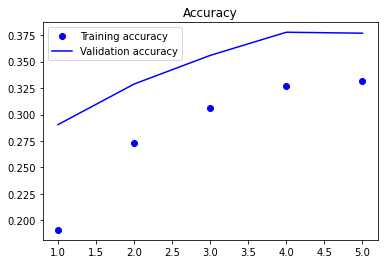

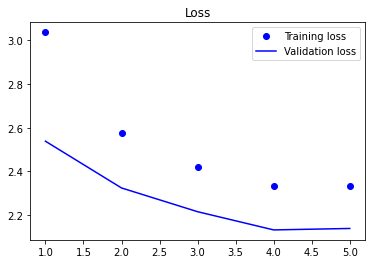

In [58]:
plots(history)

## Prediction

In [78]:
# temperature sampling based on Deep Learning book
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, preds, 1)
    return np.argmax(probs)

def generate(seed_text, length, temperature=0.2):
    generated_text = seed_text
    seed_text = seed_text.rjust(sample_length, ' ')
    seed_text = seed_text[:sample_length]
    
    for i in range(0, length):
        sampled = tokenizer.texts_to_matrix(seed_text)
        sampled = np.reshape(sampled, (1, sample_length, vocab_size))

        preds = model.predict(sampled)[0]
        next_index = sample(preds, temperature)
        next_char = ' '
        
        for char, index in tokenizer.word_index.items():
            if index == next_index:
                next_char = char
        
        generated_text += next_char
        seed_text += next_char
        seed_text = seed_text[1:] # keep seed text the same length
    
    return generated_text

In [79]:
output = generate("A", 100, temperature=0.5)
print(output)

And ford to bace and did
To bast thy bears to the bake be to to bay and pate dad endll the to my bes 
